In [358]:
import regex as re
import pandas as pd
import numpy as np
import emoji
import plotly.express as px
from collections import Counter
import matplotlib.pyplot as plt
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
% matplotlib inline

In [359]:
def startsWithDateAndTime(line):
  pattern = '^([0-9]+)(\/)([0-9]+)(\/)([0-9]+), ([0-9]+):([0-9]+)[ ]?(AM|PM|am|pm)? -'
  result = re.match(pattern,line)
  if result:
    return True
  return False

In [360]:
def isAuthorPresent(file):
  data = file.split(':')
  if(len(data))==2:
    return True
  return False

In [361]:
def getDataPoint(line):
  splitLine = line.split('-')
  dateTime = splitLine[0]
  date, time = dateTime.split(',')
  message = ' '.join(splitLine[1:])
  if(isAuthorPresent(message)):
    splitMessage = message.split(':')
    author = splitMessage[0]
    author = author.strip()
    message = ' '.join(splitMessage[1:])
  else:
    author = None
  return date.strip(), time.strip(), author, message.strip()

In [362]:
data = []
conversation = '/content/drive/MyDrive/WhatsApp Chat with Aadhar Group.txt'
with open(conversation, encoding='utf-8') as fp:
  fp.readline()
  messageBuffer = []
  date,time,author= None, None, None
  while True:
    line = fp.readline()
    if not line:
      break
    line = line.strip()
    if startsWithDateAndTime(line):
      if len(messageBuffer) > 0:
        data.append([date,time,author, ' '.join(messageBuffer)])
      messageBuffer.clear()
      date, time,author,message = getDataPoint(line)
      messageBuffer.append(message)
    else:
      messageBuffer.append(line)



In [363]:
data

[['24/09/20', '5:13 pm', None, 'Tarana created group "Aadhar Group"'],
 ['24/09/20', '5:13 pm', None, 'You were added'],
 ['11/09/21',
  '5:31 pm',
  'Shubham Sharma',
  '@919209188124 results coming now please cross check once there might be rating issue'],
 ['11/09/21', '5:33 pm', 'Pranali', 'Okay'],
 ['13/09/21', '11:09 am', 'Tarana', 'Guys let hav meeting at 11.30'],
 ['13/09/21', '11:10 am', 'Shubham Sharma', '👍'],
 ['13/09/21',
  '11:11 am',
  'Tarana',
  'Pranali u please connect from lappy n share the screen as my laptop hav problems for long calls'],
 ['13/09/21', '11:11 am', 'Pranali', 'Ok'],
 ['13/09/21', '11:26 am', 'Tarana', 'Guys connect on my link'],
 ['13/09/21', '11:33 am', 'Tarana', 'Please join'],
 ['13/09/21', '11:33 am', 'Pranali', 'Join in min'],
 ['14/09/21',
  '11:22 am',
  'Tarana',
  'guys please do not close or change tracker for dnata PMs'],
 ['14/09/21', '11:23 am', 'Neha2', '🤔'],
 ['14/09/21', '11:23 am', 'Neha2', 'If client ask then also ?'],
 ['14/09/21'

In [364]:
df = pd.DataFrame(data, columns=['Date','Time','Author','Message'])
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,Date,Time,Author,Message
0,2020-09-24,5:13 pm,None,"Tarana created group ""Aadhar Group"""
1,2020-09-24,5:13 pm,None,You were added
2,2021-11-09,5:31 pm,Shubham Sharma,@919209188124 results coming now please cross ...
3,2021-11-09,5:33 pm,Pranali,Okay
4,2021-09-13,11:09 am,Tarana,Guys let hav meeting at 11.30


In [365]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3062 entries, 0 to 3061
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     3062 non-null   datetime64[ns]
 1   Time     3062 non-null   object        
 2   Author   2932 non-null   object        
 3   Message  3062 non-null   object        
dtypes: datetime64[ns](1), object(3)
memory usage: 95.8+ KB


In [367]:
df.head()

,Date,Time,Author,Message
0,2020-09-24,5:13 pm,None,"Tarana created group ""Aadhar Group"""
1,2020-09-24,5:13 pm,None,You were added
2,2021-11-09,5:31 pm,Shubham Sharma,@919209188124 results coming now please cross ...
3,2021-11-09,5:33 pm,Pranali,Okay
4,2021-09-13,11:09 am,Tarana,Guys let hav meeting at 11.30


In [368]:
df.Author.unique()

array([None, 'Shubham Sharma', 'Pranali', 'Tarana', 'Neha2', 'Sampada@VE',
       'Sunny Kadam', 'Sunil', 'Nikhil', 'Jenil Bhau'], dtype=object)

In [369]:
df[df['Message'].values == '<Media omitted>']

,Date,Time,Author,Message
120,2021-09-16,8:36 pm,Tarana,<Media omitted>
121,2021-09-16,8:36 pm,Tarana,<Media omitted>
122,2021-09-16,8:36 pm,Tarana,<Media omitted>
127,2021-09-16,8:37 pm,Tarana,<Media omitted>
128,2021-09-16,8:39 pm,Tarana,<Media omitted>
...,...,...,...,...
2919,2021-02-12,11:26 am,Nikhil,<Media omitted>
3008,2021-03-12,9:08 am,Neha2,<Media omitted>
3014,2021-03-12,9:16 am,Neha2,<Media omitted>
3025,2021-03-12,12:19 pm,Nikhil,<Media omitted>


In [370]:
media_messages = df[df['Message'] == '<Media omitted>'].shape[0]
print(media_messages)

62


In [371]:
def splitCount(text):
  emoji_list =[]
  data= regex.findall(r'\X',text)
  for word in data:
    if any(char in emoji.UNICODE_EMOJI_ENGLISH for char in word):
      emoji_list.append(word)
  return emoji_list

In [372]:
df['Emoji_message'] = df['Message'].apply(lambda x : splitCount(x))
emojis = sum(df.Emoji_message.str.len()>0)
print(emojis)

126


In [373]:
URLPATTERN = r'(https?://\S+)'
df['urlcount'] = df.Message.apply(lambda x : re.findall(URLPATTERN,x)).str.len()
links = np.sum(df.urlcount)
print("Data science Community")
print("Media:",media_messages)
print("Links:",links)
print("Emojis: ",emojis)

Data science Community
Media: 62
Links: 105
Emojis:  126


In [374]:
media_message_df = df[df['Message'] == '<Media omitted>']
message_df = df.drop(media_message_df.index)
message_df['Letter_count'] = message_df['Message'].apply(lambda x: len(x))
message_df['word_count'] = message_df['Message'].apply(lambda x: len(x.split(' ')))
message_df['message_count'] = 1
l = [df.Author.unique()]
l= l[0][1:]

In [377]:
for i in range(len(l)):
  req_df = message_df[message_df.Author == l[i]]
  print(f'stats of {l[i]} -')
  print('Messages sent', req_df.shape[0])
  words_per_message = np.sum(req_df['word_count'])/req_df.shape[0]
  print('Words per message :', words_per_message)
  media = media_message_df[media_message_df['Author'] == l[i]].shape[0]
  print('Media Messages Sent', media)
  emoji = sum(req_df['Emoji_message'].str.len()>0)
  print('Emojis Sent', emoji)
  links = sum(req_df['urlcount'])
  print('Links sent', links)
  print()

stats of Shubham Sharma -
Messages sent 932
Words per message : 4.789699570815451
Media Messages Sent 5
Emojis Sent 38
Links sent 0

stats of Pranali -
Messages sent 266
Words per message : 7.830827067669173
Media Messages Sent 13
Emojis Sent 6
Links sent 1

stats of Tarana -
Messages sent 537
Words per message : 5.631284916201118
Media Messages Sent 14
Emojis Sent 19
Links sent 1

stats of Neha2 -
Messages sent 433
Words per message : 5.618937644341801
Media Messages Sent 13
Emojis Sent 24
Links sent 0

stats of Sampada@VE -
Messages sent 3
Words per message : 3.3333333333333335
Media Messages Sent 0
Emojis Sent 2
Links sent 0

stats of Sunny Kadam -
Messages sent 83
Words per message : 3.783132530120482
Media Messages Sent 2
Emojis Sent 8
Links sent 0

stats of Sunil -
Messages sent 181
Words per message : 5.2707182320441985
Media Messages Sent 5
Emojis Sent 6
Links sent 1

stats of Nikhil -
Messages sent 403
Words per message : 5.215880893300248
Media Messages Sent 10
Emojis Sent 23

In [378]:
total_emojis_list = list([a for b in df['Emoji_message'] for a in b])
emoji_dict = dict(Counter(total_emojis_list))
emoji_dict = sorted(emoji_dict.items(), key=lambda x:x[1],reverse=True)
emoji_dict

[('😂', 48),
 ('👍', 23),
 ('👍🏻', 12),
 ('😅', 11),
 ('😄', 9),
 ('🤣', 8),
 ('💐', 7),
 ('🤦\u200d♀️', 7),
 ('😬', 6),
 ('💣', 6),
 ('😀', 5),
 ('😒', 4),
 ('😊', 3),
 ('🥳', 3),
 ('🏃🏻\u200d♂️', 3),
 ('😳', 3),
 ('🤔', 2),
 ('👏', 2),
 ('👆🏻', 2),
 ('✌🏻', 2),
 ('❤️', 1),
 ('💃🏻', 1),
 ('🎈', 1),
 ('💫', 1),
 ('😶\u200d🌫', 1),
 ('😭', 1),
 ('🤗', 1),
 ('😥', 1),
 ('🤞🏻', 1),
 ('😆', 1),
 ('🙏', 1),
 ('😁', 1),
 ('😫', 1),
 ('🤟🏻', 1),
 ('😱', 1)]

There are 95280 words in all messages


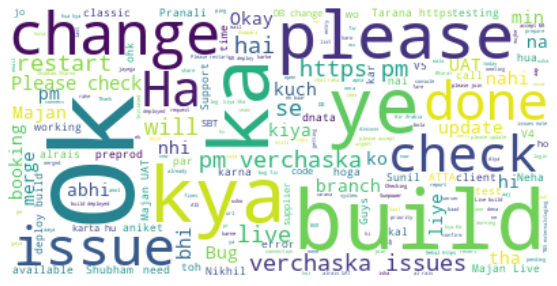

In [407]:
text = ' '.join(review for review in message_df.Message)
print('There are {} words in all messages'.format(len(text)))
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords = stopwords, background_color='white').generate(text)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('nikhil',facecolor='y', bbox_inches="tight",
            pad_inches=0.3, transparent=True)
plt.show()

Author Name :  Shubham Sharma


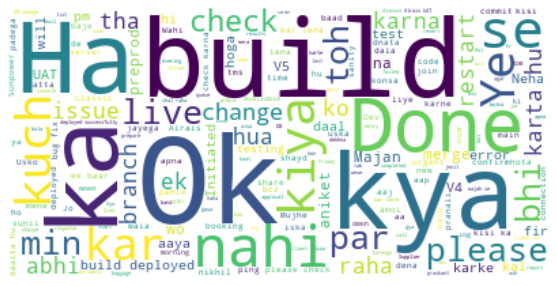

Author Name :  Pranali


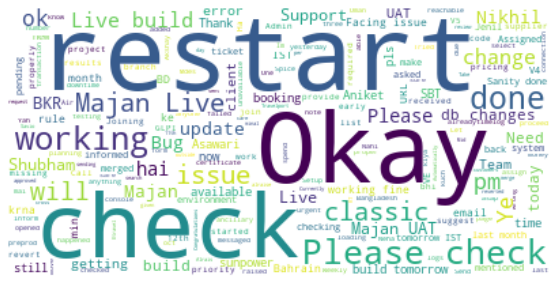

Author Name :  Tarana


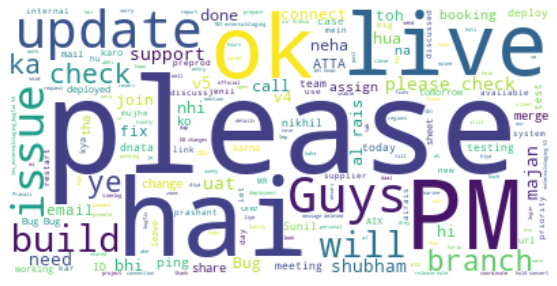

Author Name :  Neha2


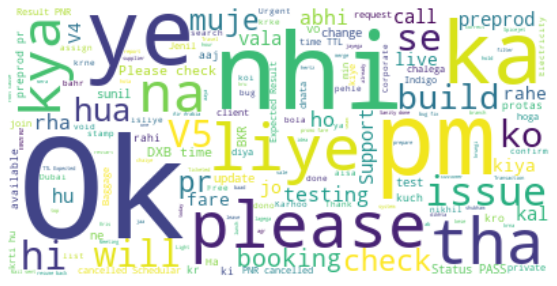

Author Name :  Sampada@VE


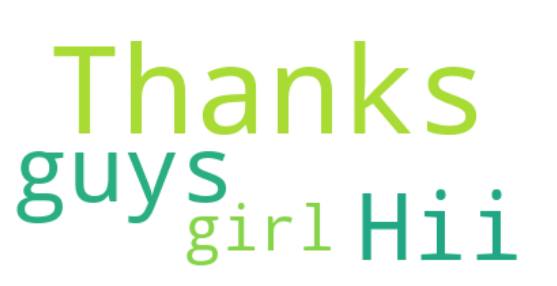

Author Name :  Sunny Kadam


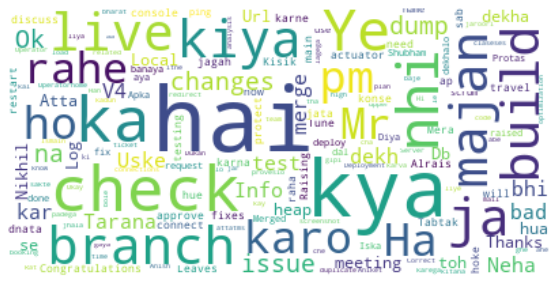

Author Name :  Sunil


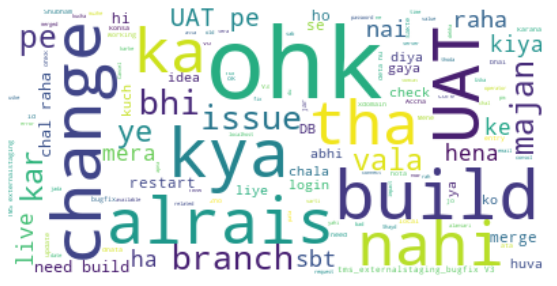

Author Name :  Nikhil


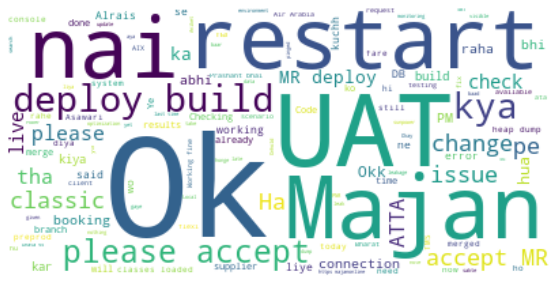

Author Name :  Jenil Bhau


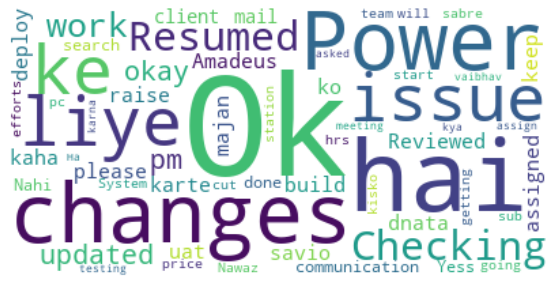

In [408]:
for i in range(len(l)):
  dummy_df=message_df[message_df.Author == l[i]]
  text = ' '.join(review for review in dummy_df['Message'])
  stopwords = set(STOPWORDS)
  print('Author Name : ',l[i])
  wordcloud = WordCloud(stopwords=stopwords, background_color='white').generate(text)
  plt.figure(figsize=(10,5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.savefig(l[i])
  plt.show()